In [59]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

Inspired by https://github.com/TeconomicsBlog/notebooks/blob/master/PrincipledInstrumentSelection.ipynb

In [60]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y



def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    # Make T a function of the W0's and unobservable (for RDD)
    W = W0 + 0.5*C + 3*X[:,0]-6*X[:,1]
    # assign treatment based on threshold along W
    T = 1*(W>0)


    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err



In [61]:
p = 10
p0 = 5
nvar = p+2 # 1 confounder and variable for randomizing treatment
tau = 1.2
corr = .5
N = 100

allX = fn_generate_multnorm(N,corr,nvar)
W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
C = allX[:,1].reshape([N,1]) # confounder
X = allX[:,2:] # observed covariates

# Make T a function of the W0's and unobservable (for RDD)
W = W0 + 0.5*C + 3*X[:,0].reshape([N,1])-6*X[:,1].reshape([N,1])
# assign treatment based on threshold along W
T = 1*(W>0)
err = np.random.normal(0,1,[N,1])
beta0 = np.random.normal(5,5,[p,1])

beta0[p0:p] = 0 # sparse model

Yrdd = tau*T - 4*W+X@beta0+0.6*C+err




(array([ 1.,  0.,  5.,  9., 17., 21., 17., 16., 11.,  3.]),
 array([-76.21997922, -62.67705372, -49.13412822, -35.59120272,
        -22.04827722,  -8.50535172,   5.03757378,  18.58049928,
         32.12342478,  45.66635028,  59.20927578]),
 <BarContainer object of 10 artists>)

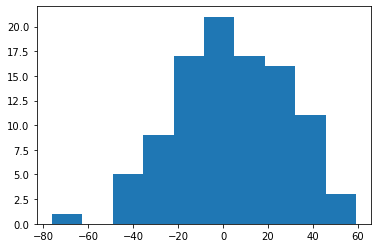

In [62]:
plt.hist(Yrdd)

In [16]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import itertools
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
import copy
random.seed(10)

In [63]:
N = 1000
tau = 2
weak = np.random.normal(0,1,[N,1])
good = np.random.normal(0,1,[N,1])
correl = np.random.normal(0,1,[N,1]) # not exognous instrument
C = 3*correl + np.random.normal(0,1,[N,1])
X = -.00001 * np.round(weak) + 2.5 * correl + 2.5 * good + .5 * C + np.random.normal(0,1,[N,1])
Y = tau * X + 1.1 * C + np.random.normal(0,1,[N,1])
df = pd.DataFrame({'Y':Y[:,0],'X':X[:,0],'correl':correl[:,0],'good':good[:,0],'weak':weak[:,0]},index = None)

In [64]:
df.head()

,Y,X,correl,good,weak
0,-12.972424,-6.012842,-0.588808,-1.657263,0.550849
1,23.654806,8.116217,2.378486,-0.486845,-0.912524
2,5.926820,1.860624,0.441214,-0.265508,-1.396208
3,-37.769825,-15.705979,-2.176071,-1.956658,-0.322946
4,17.074535,5.607653,1.817937,-0.515070,-2.358285


### Naive regression without an instrument

In [30]:
mod = sm.OLS(Y,X)
res = mod.fit()
print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          3.135e+04
Date:                Fri, 05 Feb 2021   Prob (F-statistic):                        0.00
Time:                        10:33:19   Log-Likelihood:                         -2229.1
No. Observations:                1000   AIC:                                      4460.
Df Residuals:                     999   BIC:                                      4465.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [65]:
estDict = {} # store estimates
estDict['no_instrument'] = (float(res.params),float(res.HC0_se))

In [66]:
estDict

{'no_instrument': (2.582590351934214, 0.014621943546545573)}

We can also use the IV2SLS estimator with no instruments

In [67]:
ivmod = IV2SLS(df.Y, exog = df.X, endog = None, instruments = None)
res_2sls = ivmod.fit()
print(res_2sls.summary)

                            OLS Estimation Summary                            
Dep. Variable:                      Y   R-squared:                      0.9689
Estimator:                        OLS   Adj. R-squared:                 0.9688
No. Observations:                1000   F-statistic:                 3.059e+04
Date:                Fri, Feb 12 2021   P-value (F-stat)                0.0000
Time:                        15:09:54   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              2.6004     0.0149     174.91     0.0000      2.5713      2.6295


/Users/ida/opt/anaconda3/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


### Fit using a good instrument (strong first stage and satisfies exclusion restriction)

In [68]:
ivmod = IV2SLS(df.Y, exog = None, endog = df.X, instruments = df.good)
res_2sls = ivmod.fit()
estDict['good_instrument'] = (float(res_2sls.params),float(res_2sls.std_errors))
print(res_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.9157
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9156
No. Observations:                1000   F-statistic:                    1645.8
Date:                Fri, Feb 12 2021   P-value (F-stat)                0.0000
Time:                        15:10:12   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              1.9911     0.0491     40.569     0.0000      1.8949      2.0873

Endogenous: X
Instruments: good
Robust Covariance (

### Fit using a weak instrument (satisfies exclusion restriction)

In [69]:
ivmod = IV2SLS(df.Y, exog = None, endog = df.X, instruments = df.weak)
res_2sls = ivmod.fit()
estDict['weak_instrument'] = (float(res_2sls.params),float(res_2sls.std_errors))
print(res_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.9623
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9623
No. Observations:                1000   F-statistic:                    17.369
Date:                Fri, Feb 12 2021   P-value (F-stat)                0.0000
Time:                        15:10:23   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              2.3870     0.5727     4.1677     0.0000      1.2644      3.5096

Endogenous: X
Instruments: weak
Robust Covariance (

### Fit using an instrument that doesn't satisfy the exclusion restriction (but with a strong first stage)

Instrument correlated with unobservables

In [70]:
ivmod = IV2SLS(df.Y, exog = None, endog = df.X, instruments = df.correl)
res_2sls = ivmod.fit()
estDict['failed_excl'] = (float(res_2sls.params),float(res_2sls.std_errors))
print(res_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.9594
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9594
No. Observations:                1000   F-statistic:                 1.955e+04
Date:                Fri, Feb 12 2021   P-value (F-stat)                0.0000
Time:                        15:10:58   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              2.8567     0.0204     139.83     0.0000      2.8166      2.8967

Endogenous: X
Instruments: correl
Robust Covariance

In [71]:
estimates = [tau] + list(i[0] for i in estDict.values())
bnds = [0] + list(1.96*i[1] for i in estDict.values())
x_pos = np.arange(len(estimates))
labels = ['true']+list(estDict.keys())

In [72]:
estDict

{'no_instrument': (2.582590351934214, 0.014621943546545573),
 'good_instrument': (1.9910988436149428, 0.04907956766829856),
 'weak_instrument': (2.3869998034148607, 0.5727440776150304),
 'failed_excl': (2.8566552323095524, 0.02042983578194687)}

In [37]:
labels

['true', 'no_instrument', 'good_instrument', 'weak_instrument', 'failed_excl']

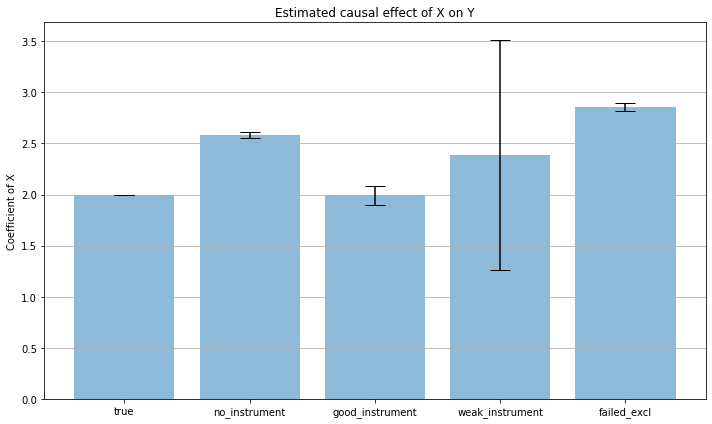

In [73]:
fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x_pos, estimates, yerr=bnds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Coefficient of X')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Estimated causal effect of X on Y')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

## Monte Carlo example

In [79]:
R = 1000
N = 1000
tau = 2

l_weak = []
l_strong = []
for r in tqdm(range(R)):
    # generate data
    weak = np.random.normal(0,1,[N,1])
    good = np.random.normal(0,1,[N,1])
    correl = np.random.normal(0,1,[N,1]) # not exognous instrument
    C = 3*correl + np.random.normal(0,1,[N,1])
    X = -.00001 * np.round(weak) + 2.5 * correl + 2.5 * good + .5 * C + np.random.normal(0,1,[N,1])
    Y = tau * X + 1.1 * C + np.random.normal(0,1,[N,1])
    df = pd.DataFrame({'Y':Y[:,0],'X':X[:,0],'correl':correl[:,0],'good':good[:,0],'weak':weak[:,0]},index = None)
    
    # estimation with weak instrument
    ivmod = IV2SLS(df.Y, exog = None, endog = df.X, instruments = df.weak)
    res_2sls = ivmod.fit()
    l_weak = l_weak + [float(res_2sls.params)]

    
    # estimation with strong instrument
    ivmod = IV2SLS(df.Y, exog = None, endog = df.X, instruments = df.good)
    res_2sls = ivmod.fit()
    l_strong = l_strong + [float(res_2sls.params)]


100%|██████████| 1000/1000 [00:15<00:00, 66.64it/s]


(array([  2.,   9.,  31., 100., 199., 250., 240., 124.,  36.,   9.]),
 array([1.8199192 , 1.85138522, 1.88285125, 1.91431728, 1.9457833 ,
        1.97724933, 2.00871536, 2.04018138, 2.07164741, 2.10311344,
        2.13457946]),
 <BarContainer object of 10 artists>)

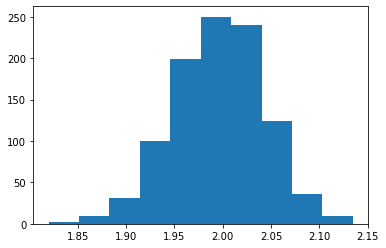

In [80]:
plt.hist(l_strong)

In [81]:
np.mean(l_strong)

1.9954114444265139

(array([  1.,   0.,   0.,   0.,   0.,   0.,   2.,   2., 992.,   3.]),
 array([-707.42250818, -622.92534886, -538.42818953, -453.9310302 ,
        -369.43387087, -284.93671155, -200.43955222, -115.94239289,
         -31.44523356,   53.05192576,  137.54908509]),
 <BarContainer object of 10 artists>)

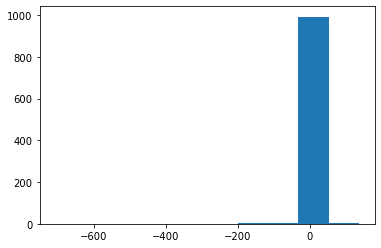

In [82]:
plt.hist(l_weak)

In [83]:
np.mean(l_weak)

1.6715375931589938

In [86]:
np.quantile(l_weak, q = [.0001,.1, .3, .5, .9, .99])

array([-654.32232836,    0.96837213,    2.26251629,    2.58687549,
          4.13499364,   12.34641333])

In [74]:
mylist = [1,2,3]

In [77]:
emptylist = []
for i in range(10):
    emptylist = emptylist + [i]

In [78]:
emptylist

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]